# Catalog builder

DEMO ...

In [1]:
# Append base directory to the system path
import os
import sys

working_directory = os.getcwd()
base_directory = working_directory + '/..'

sys.path.append(base_directory)

In [2]:
# Reload python modules automatically
%reload_ext autoreload
%autoreload 2

In [4]:
import healpy
from astropy.io import fits

# plot imports
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# numer of exposures

In [5]:
### Explain connection details...
from ipywidgets import widgets
import notebook

user = widgets.Text(description='DB User', placeholder='Insert DB user', description_tooltip='DB User')
display(user)
password = widgets.Password(description='DB Pass', placeholder='Insert DB password', description_tooltip='DB Pass')
display(password)
host = widgets.Text(description='DB Host', description_tooltip='DB Host', value='desdb4.linea.gov.br')
display(host)
port = widgets.Text(description='DB Port', description_tooltip='DB Port', value='5432')
display(port)

def handle_submit(sender):
    print ("Credentials stored.")

user.on_submit(handle_submit)
password.on_submit(handle_submit)
host.on_submit(handle_submit)
port.on_submit(handle_submit)

Text(value='', description='DB User', description_tooltip='DB User', placeholder='Insert DB user')

Password(description='DB Pass', description_tooltip='DB Pass', placeholder='Insert DB password')

Text(value='desdb4.linea.gov.br', description='DB Host', description_tooltip='DB Host')

Text(value='5432', description='DB Port', description_tooltip='DB Port')

Credentials stored.


In [6]:
# DB connection
# REVIEW:
# - conenction parameters are hardcoded and exposed
# - user permissions

import sqlalchemy
import sqlparse
import warnings
warnings.simplefilter("ignore", category=sqlalchemy.exc.SAWarning)

# module to facilitate the DB connection and the creation and deletion of the tables
from src import db
from src import sqlalchemy_extension as sql_op

from src import queries_y1 as qy1

url = sqlalchemy.engine.url.URL('postgresql',
                                username=user.value,
                                password=password.value,
                                host=host.value,
                                port=port.value,
                                database='gavo'
                               )
dal = db.DataAccessLayer(url)

# Step 1 - Region selection

Remove regions with instrumental problmens
Informations about survey conditions
Depth map
foreground objects
detection fraction

Steps:
1. Select an ancillary map from the list above.
2. Build a sql statement. -show query before execution-
3. Create table from sql statement
4. Report info and statistics about the table -Product log-

In [8]:
#maps_path = '/archive/staging/DES/Y3_GOLD/maps/'
maps_path = '/archive/user/julia/jupyter/data/maps/'

In [16]:
footprint_ra, footprint_dec = np.loadtxt(maps_path + 'des-round17-poly.txt', unpack=True)

## 1.1 - Number of exposures maps

In [11]:
nexp_map_file = maps_path + 'y3a2_i_o.4096_t.32768_N_IMAGES_EQU.fits.gz'
nexp_map = healpy.read_map(nexp_map_file,nest=True)

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = EXPLICIT


<IPython.core.display.Javascript object>


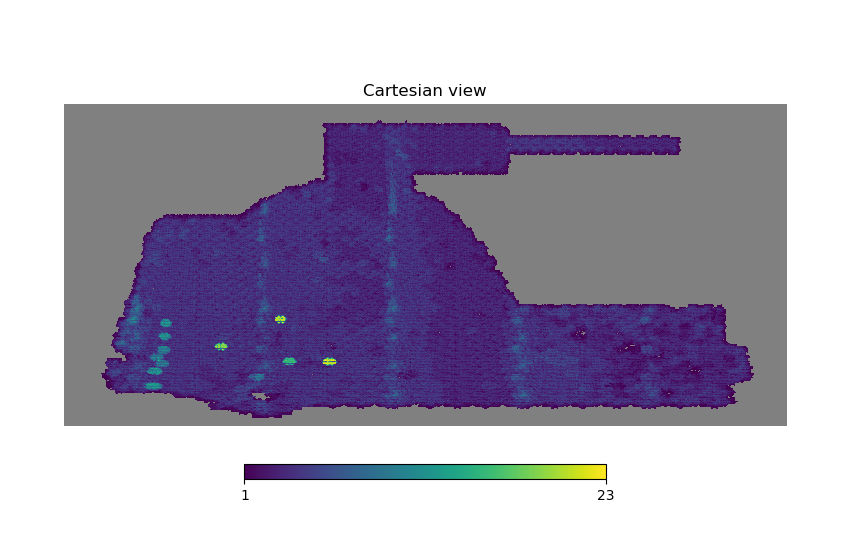

In [25]:
nexp_proj_map = healpy.visufunc.cartview(map = nexp_map, nest=True, lonra = [-70,110], latra = [-70,10], return_projected_map=True)
plt.show()

<IPython.core.display.Javascript object>


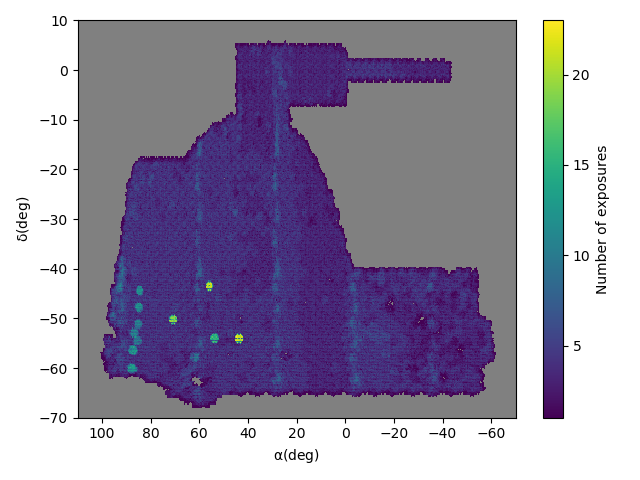

In [36]:
#healpy.graticule()
ext = [110., -70., -70., 10.]
fig = plt.figure()
plt.imshow(nexp_proj_map, extent=ext, aspect='auto', origin='lower', interpolation='None', 
           vmin=np.min(nexp_proj_map), vmax=np.max(nexp_proj_map))#, cmap=None)
#cbaxes = fig.add_axes([0.80, 0.11, 0.015, 0.9])
plt.colorbar(label='Number of exposures', ticks=np.arange(0,np.max(nexp_proj_map),5))
plt.xlabel(r'$\mathrm{\alpha(deg)}$')
plt.ylabel(r'$\mathrm{\delta(deg)}$')
plt.ylim([-70., 10.])
plt.xlim([110., -70.])
plt.tight_layout()
plt.show()

In [ ]:
# Load tables and inspect columns
# REVIEW:
# - how to choose the available tables outside E2E env ? -> Use 
# - list availabe tables
table_mangle_i = sqlalchemy.Table("mangle_maps_4096_ring_frac_i_10029940", dal.meta, autoload=True, schema="y1a1_coadd_cosmos_d04").alias('table_mangle_i')

print("Inspecting columns from table:\n")
print(str(table_mangle_i.c.values()))

In [ ]:
data = dal.select_columns('mangle_maps_4096_ring_frac_i_10029940', schema='y1a1_coadd_cosmos_d04', columns=['signal'])

In [ ]:
Remove# plt.show()
fig, axes = plt.subplots()
n, bins, patches = axes.hist(np.array(data), 25, facecolor='red', alpha=0.50)
axes.set_xlabel('xlabel')
axes.set_ylabel('ylabel')
fig.show()

In [ ]:
data = dal.select_columns('mangle_maps_4096_ring_frac_i_10029940', schema='y1a1_coadd_cosmos_d04', columns=['ra', 'dec', 'signal'])
pt.plot_map(data)

In [ ]:
ra, dec = np.array(dal.select_columns('mangle_maps_4096_ring_frac_i_10029940', schema='y1a1_coadd_cosmos_d04', columns=['ra', 'dec'])).T

fig, axes = plt.subplots()
axes.scatter(ra, dec, s=.1)
axes.set_xlabel('RA [DEG]')
axes.set_ylabel('DEC [DEG]')
fig.show()

In [ ]:
data = dal.select_columns('mangle_maps_4096_ring_frac_i_10029940', schema='y1a1_coadd_cosmos_d04', columns=['signal'])
pt.plot_signal_area(data, NSIDE=4096)

In [ ]:
input_params = {}
intermediate_tables = {}

input_params['schema'] = 'y1a1_coadd_cosmos_d04'
input_params['table'] = 'mangle_maps_4096_ring_frac_i_10029940'
input_params['signal'] = 0.8

operation = qy1.GreatEqualThanSignalColumn(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_table_mangle_i')

In [ ]:
original_data = dal.select_columns('mangle_maps_4096_ring_frac_i_10029940', schema='y1a1_coadd_cosmos_d04', columns=['signal'])
filtered_data = dal.select_columns("tmp_table_mangle_i", columns=['signal'])

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
n, bins, patches = ax1.hist(np.array(original_data), 25, facecolor='red', alpha=0.50)
ax1.set_xlabel('xlabel')
ax1.set_ylabel('ylabel')

n, bins, patches = ax2.hist(np.array(filtered_data), 25, facecolor='red', alpha=0.50)
ax2.set_xlabel('Xlabel')
ax2.set_ylabel('Ylabel')

fig.show()

In [ ]:
# Surface plots
from src import plots as pt

data = dal.select_columns('tmp_table_mangle_i', columns=['ra', 'dec', 'signal'])
pt.plot_map(data)

In [ ]:
input_params = {}
intermediate_tables = {}

input_params['schema'] = 'y1a1_coadd_cosmos_d04'
input_params['table'] = 'mangle_maps_4096_ring_frac_g_10029940'
input_params['signal'] = 0.9

operation = qy1.GreatEqualThanSignalColumn(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_table_mangle_g')

In [ ]:
data = dal.select_columns("tmp_table_mangle_g", columns=['signal'])

fig, axes = plt.subplots()
n, bins, patches = axes.hist(np.array(data), 25, facecolor='red', alpha=0.50)
axes.set_xlabel('xlabel')
axes.set_ylabel('ylabel')
fig.show()

# Review

* The pixels have different areas. How to combine them?

In [ ]:
input_params = {}
intermediate_tables = {}

intermediate_tables['tables'] = []
intermediate_tables['tables'].append({'schema': dal.schema_output, 'table': 'tmp_table_mangle_i'})
intermediate_tables['tables'].append({'schema': dal.schema_output, 'table': 'tmp_table_mangle_g'})

operation = qy1.CombinedMaps(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_table_mangle_combined')

In [ ]:
data = dal.select_columns('tmp_table_mangle_combined', columns=['ra', 'dec', 'signal'])
pt.plot_map(data)

In [ ]:
table_bad_regions = sqlalchemy.Table("y1a1_coadd_cosmos_d04_bright_mask_4096_ring_10023572", dal.meta, autoload=True, schema="bright_mask").alias('table_bad_regions')
str(table_bad_regions.c.values())

# Review

* nomenclature of maps  
* flag conditions  
* are the maps ingested in the DB correct?

In [ ]:
input_params = {}
intermediate_tables = {}

input_params['schema'] = 'bright_mask'
input_params['table'] = 'y1a1_coadd_cosmos_d04_bright_mask_4096_ring_10023572'

filters = [32, 8, 4, 2]
input_params['filters'] = filters

operation = qy1.BadRegions(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_table_bad_regions')

# Review
* jupyter-vac kernel. What is the skymapper version?

In [ ]:
data = dal.select_columns('tmp_table_bad_regions', columns=['ra', 'dec', 'signal'])
pt.plot_map(data)

# Depth Map

In [ ]:
# Add comments.
table_depth_i = sqlalchemy.Table("y1a1_coadd_cosmos_d04_5_auto_4096_ring_i_10024579", dal.meta, autoload=True, schema="depth_maps").alias('table_mangle_i')
str(table_depth_i.c.values())

In [ ]:
# Inspect SQL
stm = sqlalchemy.select([table_depth_i]).where(table_depth_i.c.signal >= 24)
print(sqlparse.format(str(stm), reindent=True, keyword_case='upper'))

In [ ]:
%%time
dal.create_table('tmp_table_depth_i', stm)

In [ ]:
data = dal.select_columns('tmp_table_depth_i', columns=['signal'])

In [ ]:
fig, axes = plt.subplots()
n, bins, patches = axes.hist(np.array(data), 25, facecolor='red', alpha=0.50)
axes.set_xlabel('mlim')
axes.set_ylabel('number of pixels')
fig.show()

In [ ]:
data = dal.select_columns('tmp_table_depth_i', columns=['ra', 'dec', 'signal'])
pt.plot_map(data)

In [ ]:
data = dal.select_columns('tmp_table_depth_i', columns=['signal'])
pt.plot_signal_area(data, NSIDE=4096)

# Insert bright mask ?

In [ ]:
# Footprint
input_params = {}
intermediate_tables = {}

intermediate_tables['good_regions'] = []
intermediate_tables['bad_regions'] = []

intermediate_tables['good_regions'].append({'schema': dal.schema_output, 'table': 'tmp_table_depth_i'})
intermediate_tables['good_regions'].append({'schema': dal.schema_output, 'table': 'tmp_table_mangle_i'})
intermediate_tables['bad_regions'].append({'schema': dal.schema_output, 'table': 'tmp_table_bad_regions'})

operation = qy1.Footprint(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_footprint')

In [ ]:
# data = dal.select_columns('tmp_footprint', columns=['signal'])

In [ ]:
data = dal.select_columns('tmp_footprint', columns=['ra', 'dec', 'signal'])
pt.plot_map(data)

# Review

* The reference band to calculate the area

In [ ]:
data = dal.select_columns('tmp_footprint', columns=['signal'])
pt.plot_signal_area(data, NSIDE=4096)

# Step 2 - Object Selection

Reduciton  
Cuts  
Bitmask  
Column selection

In [ ]:
# Zero Point
input_params = {}
intermediate_tables = {}

input_params['zero_point'] = {'schema': 'zeropoint_correction', 'table': 'slr_zeropoints_10023395'}
input_params['coadd_objects'] = {'schema': 'y1a1_coadd_cosmos_d04', 'table': 'coadd_objects'}

input_params['correction_type'] = 'extinction_and_slr'
input_params['add_slr_shift_columns'] = True
input_params['add_cuts_columns'] = True
input_params['mag_type'] = 'auto'
input_params['columns'] = ["mag_model_g", "mag_model_r", "mag_model_i", "mag_model_z", "mag_model_y", "mag_auto_g", "mag_auto_r", "mag_auto_i", "mag_auto_z", "mag_auto_y"]

operation = qy1.ZeroPoint(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_zero_point')

In [ ]:
# Reduction
input_params = {}
intermediate_tables = {}

input_params['coadd_objects_ring'] = {'schema': 'y1a1_coadd_cosmos_d04', 'table': 'coadd_objects_pixel_4096_ring_10029940'}
intermediate_tables['footprint'] = {'schema': dal.schema_output, 'table': 'tmp_footprint'}

operation = qy1.Reduction(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_reduction')

In [ ]:
# Cuts
input_params = {}
intermediate_tables = {}

input_params['coadd_objects'] = {'schema': 'y1a1_coadd_cosmos_d04', 'table': 'coadd_objects'}
input_params['mag_type'] = 'auto'
input_params['sextractor_flags'] = [0, 1, 2]
input_params['sextractor_bands'] = ['i']
input_params['additional_cuts'] = ['remove_bbj', 'spreaderr_model', 'bad_astronomic_colors']
input_params['niter_model'] = []
input_params['sn_cuts'] = {}
input_params['magnitude_limit'] = {'i': '22'}
input_params['bright_magnitude'] = {'i': '15'}
input_params['color_cuts'] = {'gr':[-2, 4], 'ri':[-2, 4], 'iz':[-2, 4], 'zy':[-2, 4]}

intermediate_tables['zero_point'] = {'schema': dal.schema_output, 'table': 'tmp_zero_point'}
intermediate_tables['reduction'] = {'schema': dal.schema_output, 'table': 'tmp_reduction'}

operation = qy1.Cuts(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_cuts')

In [ ]:
# rever plot = colunas ra e dec não existentes
# data = dal.select_columns('tmp_cuts', columns=['ra', 'dec'])
# pt.plot_catalog(4096, data)

In [ ]:
# Bitmask
input_params = {}
intermediate_tables = {}

input_params['molygon_coadds'] = {'schema': 'y1a1_coadd_cosmos_d04', 'table': 'coadd_objects_molygon_10029940'}
input_params['molygon'] = {'schema': 'y1a1_coadd_cosmos_d04', 'table': 'molygon_10029940'}
# mangle_bitmask
# g,r,i,z,Y
input_params['mangle_bitmask'] = ['i']

intermediate_tables['last_table'] = {'schema': dal.schema_output, 'table': 'tmp_cuts'}

operation = qy1.Bitmask(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_bitmask')

In [ ]:
# Object Selection
input_params = {}
intermediate_tables = {}

input_params['coadd_objects'] = {'schema': 'y1a1_coadd_cosmos_d04', 'table': 'coadd_objects'}
input_params['columns_data_set'] = ['a_image', 'alphawin_j2000_y', 'bwin_image_r', 'chi2_psf_r', 'ra', 'dec']
input_params['columns_zero_point'] = ['mag_model_g', 'mag_model_r', 'mag_auto_z', 'mag_auto_y']

intermediate_tables['last_table'] = {'schema': dal.schema_output, 'table': 'tmp_bitmask'}
intermediate_tables['zero_point'] = {'schema': dal.schema_output, 'table': 'tmp_zero_point'}

operation = qy1.ObjectSelection(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_object_selection')

In [ ]:
data = dal.select_columns('tmp_object_selection', columns=['ra', 'dec'])
pt.plot_catalog(4096, data)

In [ ]:
# PhotoZ
input_params = {}
intermediate_tables = {}

input_params['zmin'] = 0
input_params['zmax'] = 2
input_params['pz_tables'] = [{'schema': 'photoz_compute', 'table': 'dnf_10027425'}]

intermediate_tables['last_table'] = {'schema': dal.schema_output, 'table': 'tmp_object_selection'}

operation = qy1.PhotoZ(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_photoz')

In [ ]:
intermediate_tables = {"cur_table": {"schema": dal.schema_output, "table": 'tmp_photoz'},
                      "coadd_objects": {'schema': 'y1a1_coadd_cosmos_d04', 'table': 'coadd_objects'}}
data = dal.prepare_data_to_plot_catalog(intermediate_tables)
pt.plot_catalog(4096, data)

In [ ]:
# Star Galaxy Separation
input_params = {}
intermediate_tables = {}

input_params['select_starts'] = True
input_params['select_galaxies'] = False
input_params['reference_band'] = 'g'
input_params['sg_tables'] = [{'schema': 'sg_separation', 'table': 'modest_10022759'}]

intermediate_tables['last_table'] = {'schema': dal.schema_output, 'table': 'tmp_photoz'}

operation = qy1.SgSeparation(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_sg_separation')

In [ ]:
intermediate_tables = {"cur_table": {"schema": dal.schema_output, "table": 'tmp_sg_separation'},
                      "coadd_objects": {'schema': 'y1a1_coadd_cosmos_d04', 'table': 'coadd_objects'}}
data = dal.prepare_data_to_plot_catalog(intermediate_tables)
pt.plot_catalog(4096, data)

In [ ]:
# Galaxy Properties - only add additional columns at the end of the table.
input_params = {}
intermediate_tables = {}

input_params['columns'] = ["mod_best", "ebv_best", "k_cor_g", "k_cor_i", "k_cor_r", "k_cor_y", "k_cor_z", "mag_abs_g", "mag_abs_i", "mag_abs_r", "mag_abs_y", "mag_abs_z", "mass_best", "age_best", "sfr_best"]
input_params['gp_tables'] = [{'schema': 'gal_properties', 'table': 'lephare_10022885'}]

intermediate_tables['last_table'] = {'schema': dal.schema_output, 'table': 'tmp_sg_separation'}

operation = qy1.GalaxyProperties(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_galaxy_properties')